## Alternative encodings

The use of [-1, +1], +, \*, and roll is one complete computational algebra of many that can be used for hypercomputing. 

An alternative framework, developed by Plate, and which is used by Eliasmith, uses unitary hypervectors chosen at random from the high-dimensional unit hypersphere as its basic elements. The addition operation still performs the same function, but the roll and binding operations are transformed into "circular convolution", $\oplus$. 

Here, I will attempt to perform the same memory experiments and explore whether the alternative encodings have any advantages. But more importantly, we will get a sense of hypercomputing more generally, because each of these encodings are just slightly different ways of doing the same thing, namely computation.


In [1]:
import random_idx
import utils
import pickle
import time
import string
from pylab import *
%matplotlib inline

height has been deprecated.

2016-04-08 14:38


In [2]:
import nengo

/home/epaxon/anaconda2/lib/python2.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/home/epaxon/anaconda2/lib/python2.7/site-packages/IPython/nbconvert.py:13: ShimWarning: The `IPython.nbconvert` package has been deprecated. You should import from ipython_nbconvert instead.
  "You should import from ipython_nbconvert instead.", ShimWarning)
/home/epaxon/anaconda2/lib/python2.7/site-packages/IPython/nbformat.py:13: ShimWarning: The `IPython.nbformat` package has been deprecated. You should import from nbformat instead.
  "You should import from nbformat instead.", ShimWarning)
/home/epaxon/anaconda2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widget

In [3]:
fdict = open("raw_texts/texts_english/alice_in_wonderland.txt")
alice_text = fdict.read().lower()
punct = string.punctuation + string.digits

for i in punct:
    if i == '-':
        alice_text = alice_text.replace(i, ' ')
    else:
        alice_text = alice_text.replace(i, '')
    
alice_text = alice_text.replace('\n', ' ')
alice_text = alice_text.replace('\r','')
alice_text = alice_text.replace('\t','')
alice_text = alice_text[504:137330] # taking out the header/footer text

I am using nengo, which is Eliasmith's code base, but in this document I am just using it to pick random samples. 

In this framework, I am using unit vectors, which are chosen from the surface of a unit hypersphere. This is a function in nengo, but just returns a numpy array (this is the full extent of nengo for these capacity experiments).

However, after looking at Plate 1995, he just uses independent vectors, not enforcing the unit norm. He also has derivations of the capacity, but this may have to be reconfigured (still should be quite close, can recalculate for his framework as well).

In [4]:
N = 10000
hs = nengo.dists.UniformHypersphere()
letter_vectors = hs.sample(len(random_idx.alphabet), N)

In [5]:
letter_vectors

array([[-0.00909061,  0.00961209, -0.00384183, ..., -0.00813408,
        -0.00751412,  0.00071594],
       [ 0.00246004,  0.00081615,  0.00354875, ...,  0.00107643,
         0.00482092, -0.01145132],
       [-0.00710042,  0.00645879,  0.00834363, ..., -0.00150652,
        -0.00560817, -0.00090971],
       ..., 
       [-0.00046549,  0.00133473,  0.00496576, ...,  0.0041063 ,
         0.00623979,  0.00573651],
       [-0.0024262 , -0.00330119,  0.01225835, ..., -0.00952046,
        -0.00252928, -0.00752615],
       [-0.00090653, -0.00542925,  0.0021108 , ..., -0.00639049,
        -0.00926398,  0.01302597]])

In [6]:
letters = random_idx.alphabet.replace(' ', '_')

For doing the basic stats on the letters, we did not even need to use roll or bind!

In [7]:
alice_vector1 = np.zeros(N)

for l in alice_text:
    alice_vector1 += letter_vectors[random_idx.alphabet.find(l), :]

alice_vector1 = alice_vector1 / len(alice_text)
hypsph_prob1 = np.dot(letter_vectors, alice_vector1.T)

In [8]:
letter_counts = np.zeros(len(random_idx.alphabet))

for i,letter in enumerate(random_idx.alphabet):
    letter_counts[i] = alice_text.count(letter)

letter_prob = letter_counts / sum(letter_counts)

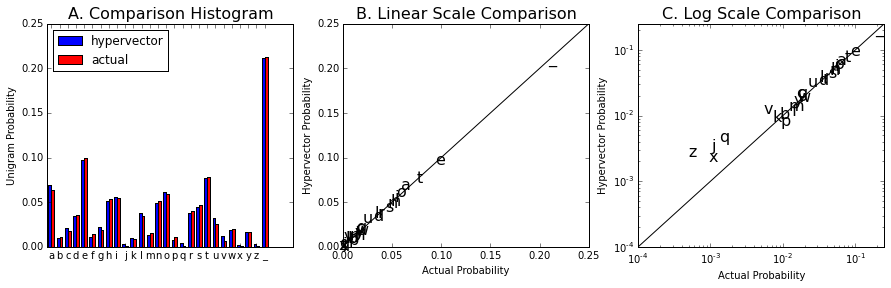

In [9]:
figure(figsize=(15,4))

ax1 = subplot(131)

bar(arange(len(hypsph_prob1))+0.15, abs(hypsph_prob1), width=0.35, color='b', label='hypervector')
bar(arange(len(letter_prob))+0.5, letter_prob, width=0.35, color='r', label='actual')

ax1.set_xticks(arange(len(hypsph_prob1))+0.5)
th = ax1.set_xticklabels(list(letters))

ax1.legend(loc='upper left')
ax1.set_ylabel('Unigram Probability')
ax1.set_title('A. Comparison Histogram', fontsize=16)

plt_range = [1e-4, 0.25]

ax2 = subplot(132)
plot(plt_range, plt_range, 'k')

ax3 = subplot(133)
plot(plt_range, plt_range, 'k')

for i,l in enumerate(letters):
    if letter_prob[i] < 1e-7:
        continue
        
    # abs to deal with potential negatives
    ax2.text(letter_prob[i], abs(hypsph_prob1[i]), 
         l, fontsize=16, ha='center', va='center')
    
    ax3.text(letter_prob[i], abs(hypsph_prob1[i]), 
         l, fontsize=16, ha='center', va='center')

ax2.set_xlim(plt_range)
ax2.set_ylim(plt_range)

ax2.set_xlabel('Actual Probability')
ax2.set_ylabel('Hypervector Probability')
ax2.set_title('B. Linear Scale Comparison', fontsize=16)

ax3.set_xlim(plt_range)
ax3.set_xscale('log')
ax3.set_ylim(plt_range)
ax3.set_yscale('log')

ax3.set_xlabel('Actual Probability')
ax3.set_ylabel('Hypervector Probability')
ax3.set_title('C. Log Scale Comparison', fontsize=16)

In [10]:
alice_vector_log = np.zeros(N)
letter_val = np.zeros(len(alice_text))
count_vector = hs.sample(1, N)[0, :]

for il,l in enumerate(alice_text):
    # Read out the log count of the letter value
    letter_val[il] = np.dot(letter_vectors[random_idx.alphabet.find(l),:], alice_vector_log)
    # Only increment the hypervector value for this letter based on its count
    alice_vector_log += 1.0 / (np.exp(letter_val[il])) * letter_vectors[random_idx.alphabet.find(l),:]
    
    # store the count in the hypervector too, we need this to decode the probability
    cv = np.dot(count_vector.T, alice_vector_log) 
    alice_vector_log += 1.0 / (np.exp(cv)) * count_vector

alice_vector_log = alice_vector_log
hyp_prob_log = np.dot(letter_vectors, alice_vector_log.T)

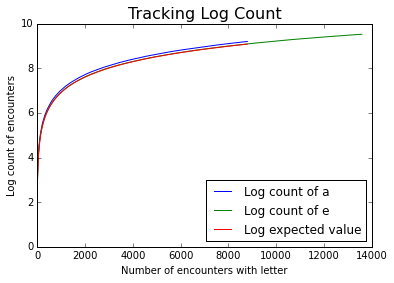

In [11]:
import re
idxs1 = np.array([match.start() for match in re.finditer('a', alice_text)])
idxs2 = np.array([match.start() for match in re.finditer('e', alice_text)])

plot(letter_val[idxs1], label='Log count of a')
plot(letter_val[idxs2], label='Log count of e')
plot(np.log(arange(len(idxs1))+1), label='Log expected value')
legend(loc='lower right')
xlabel('Number of encounters with letter')
ylabel('Log count of encounters')
title('Tracking Log Count', fontsize=16)

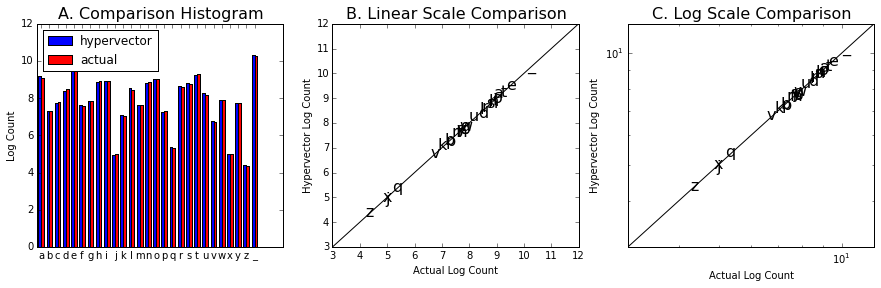

In [12]:
figure(figsize=(15,4))

ax1 = subplot(131)

bar(arange(len(hyp_prob_log))+0.15, hyp_prob_log, width=0.35, color='b', label='hypervector')
bar(arange(len(letter_prob))+0.5, np.log(letter_counts), width=0.35, color='r', label='actual')

ax1.set_xticks(arange(len(hyp_prob_log))+0.5)
th = ax1.set_xticklabels(list(letters))

ax1.legend(loc='upper left')
ax1.set_ylabel('Log Count')
ax1.set_title('A. Comparison Histogram', fontsize=16)

plt_range = [3e0, 12]

ax2 = subplot(132)
plot(plt_range, plt_range, 'k')

ax3 = subplot(133)
plot(plt_range, plt_range, 'k')

for i,l in enumerate(letters):
    if letter_prob[i] < 1e-7:
        continue
        
    # abs to deal with potential negatives
    ax2.text(np.log(letter_counts[i]), abs(hyp_prob_log[i]), 
         l, fontsize=16, ha='center', va='center')
    
    ax3.text(np.log(letter_counts[i]), abs(hyp_prob_log[i]), 
         l, fontsize=16, ha='center', va='center')

ax2.set_xlim(plt_range)
ax2.set_ylim(plt_range)

ax2.set_xlabel('Actual Log Count')
ax2.set_ylabel('Hypervector Log Count')
ax2.set_title('B. Linear Scale Comparison', fontsize=16)

ax3.set_xlim(plt_range)
ax3.set_xscale('log')
ax3.set_ylim(plt_range)
ax3.set_yscale('log')

ax3.set_xlabel('Actual Log Count')
ax3.set_ylabel('Hypervector Log Count')
ax3.set_title('C. Log Scale Comparison', fontsize=16)

In [13]:
# Can get the full probability reconstruction by decoding each letter and the count
hyp_prob_log_r = np.exp((np.dot(letter_vectors, alice_vector_log.T) 
                         - np.dot(count_vector, alice_vector_log.T)))

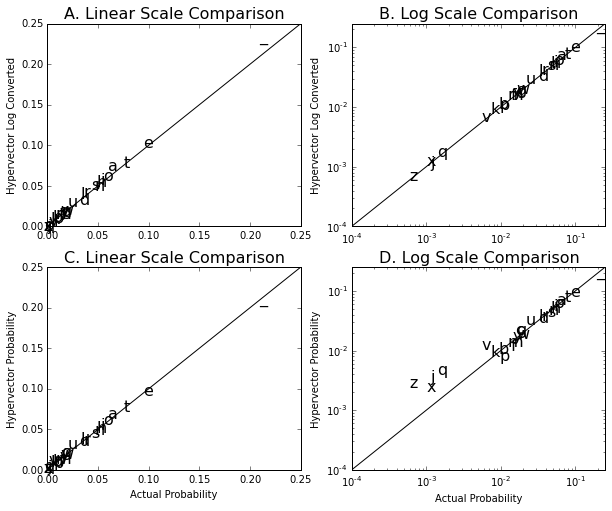

In [14]:
figure(figsize=(10, 8))

plt_range = [1e-4, 0.25]

ax1=subplot(221)
ax1.plot(plt_range, plt_range, 'k')
ax2=subplot(222)
ax2.plot(plt_range, plt_range, 'k')
ax3=subplot(223)
ax3.plot(plt_range, plt_range, 'k')
ax4=subplot(224)
ax4.plot(plt_range, plt_range, 'k')

for i,ll in enumerate(letters):
    if letter_counts[i] < 1:
        continue
    
    # adding plt_range[0] so that log(1)=0 doesnt plot at -infinity on the log axis
    ax1.text(letter_counts[i]/len(alice_text) + plt_range[0], hyp_prob_log_r[i] + plt_range[0],
         ll, fontsize=16, ha='center', va='center')    
    ax3.text(letter_counts[i]/len(alice_text) + plt_range[0], abs(hypsph_prob1[i]) + plt_range[0],
         ll, fontsize=16, ha='center', va='center')
    
    ax2.text(letter_counts[i]/len(alice_text) + plt_range[0], hyp_prob_log_r[i] + plt_range[0], 
         ll, fontsize=16, ha='center', va='center')
    ax4.text(letter_counts[i]/len(alice_text) + plt_range[0], abs(hypsph_prob1[i]) + plt_range[0],
         ll, fontsize=16, ha='center', va='center')

ax1.set_xlim([0, 0.25])
ax1.set_ylim([0, 0.25])

ax1.set_ylabel('Hypervector Log Converted')
ax1.set_title('A. Linear Scale Comparison', fontsize=16)

ax3.set_xlim([0, 0.25])
ax3.set_ylim([0, 0.25])

ax3.set_xlabel('Actual Probability')
ax3.set_ylabel('Hypervector Probability')
ax3.set_title('C. Linear Scale Comparison', fontsize=16)

ax2.set_xlim([1e-4, 0.25])
ax2.set_xscale('log')
ax2.set_ylim([1e-4, 0.25])
ax2.set_yscale('log')

ax2.set_ylabel('Hypervector Log Converted')
ax2.set_title('B. Log Scale Comparison', fontsize=16)

ax4.set_xlim([1e-4, 0.25])
ax4.set_xscale('log')
ax4.set_ylim([1e-4, 0.25])
ax4.set_yscale('log')

ax4.set_xlabel('Actual Probability')
ax4.set_ylabel('Hypervector Probability')
ax4.set_title('D. Log Scale Comparison', fontsize=16)

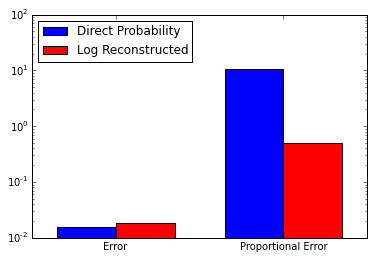

In [15]:
prob_error = (sum((letter_prob - abs(hypsph_prob1))**2))**0.5
prob_log_error = (sum((letter_prob - np.exp(abs(hyp_prob_log))/len(alice_text))**2))**0.5

# is this the correct way of computing it? it doesn't seem right...
prob_perror = (sum((letter_prob - abs(hypsph_prob1))/letter_prob)**2)**0.5
prob_log_perror = (sum((letter_prob - np.exp(abs(hyp_prob_log))/len(alice_text))/letter_prob)**2)**0.5

bar(np.array([0, 1]) + 0.15, np.array([prob_error, prob_perror]), 
    width=0.35, label='Direct Probability', color='b')
bar(np.array([0, 1]) + 0.5, np.array([prob_log_error, prob_log_perror]), 
    width=0.35, label='Log Reconstructed', color='r')

ax = gca()
ax.set_yscale('log')
ax.legend(loc='upper left')
ax.set_xticks([0.5, 1.5])
ax.set_xticklabels(['Error', 'Proportional Error'])

In [16]:
test_joints = ['ae', 'ab', 'ed', 'xy', 'qu', 'pax', 'is', 'awe', 'some']

actual_joint_prob = np.ones(len(test_joints))
hyp_joint_prob_log = np.ones(len(test_joints))
hyp_joint_prob = np.ones(len(test_joints))

for ti, joint_letters in enumerate(test_joints):
    joint_vec = np.zeros(N)
    actual_joint_prob[ti] = 1
    hyp_joint_prob[ti] = 1

    for l in joint_letters:
        lidx = random_idx.alphabet.find(l)
        joint_vec += letter_vectors[lidx,:]
    
        actual_joint_prob[ti] *= letter_prob[lidx]
        hyp_joint_prob[ti] *= abs(hypsph_prob1[lidx])
    
    joint_vec -= count_vector * len(joint_letters)

    hyp_joint_prob_log[ti] = np.exp(np.dot(joint_vec, alice_vector_log.T))
    


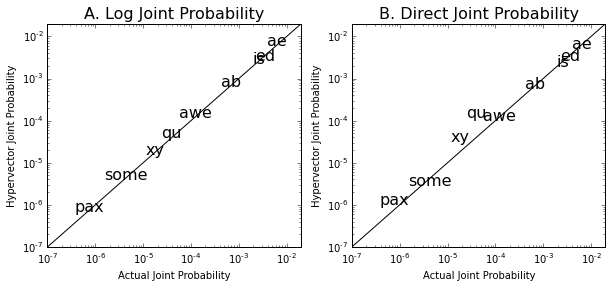

In [17]:
figure(figsize=(10,4))

plt_range = [1e-7, 2e-2]

ax = subplot(121)
plot(plt_range, plt_range, 'k')
for ti, ll in enumerate(test_joints):
    text(actual_joint_prob[ti], hyp_joint_prob_log[ti], ll,
        fontsize=16, ha='center', va='center')
    
ax = gca()
ax.set_xlim(plt_range)
ax.set_xscale('log')
ax.set_ylim(plt_range)
ax.set_yscale('log')
ax.set_xlabel('Actual Joint Probability')
ax.set_ylabel('Hypervector Joint Probability')
ax.set_title('A. Log Joint Probability', fontsize=16)

ax2 = subplot(122)
plot(plt_range, plt_range, 'k')
for ti, ll in enumerate(test_joints):
    text(actual_joint_prob[ti], hyp_joint_prob[ti], ll,
        fontsize=16, ha='center', va='center')
    
ax = gca()
ax.set_xlim(plt_range)
ax.set_xscale('log')
ax.set_ylim(plt_range)
ax.set_yscale('log')
ax.set_xlabel('Actual Joint Probability')
ax.set_ylabel('Hypervector Joint Probability')
ax.set_title('B. Direct Joint Probability', fontsize=16)

Huzzah! So, this is very simple and is pretty much exactly the same. This is because we have not needed to use the binding operation thus far. The + and similarity operators (dot) are the same in both frameworks!

However, when we start using the binding operation, $\oplus$, there are two key differences. First, we have to implement the binding operation funciton, which requires extra horsepower compared to roll and \*. Second, in the hypersphere encoding, the vectors are no longer their self inverses. With encoding in which all vectors are $[-1, +1]$, each hypervector representation is its self inverse (i.e. $A*A=I$, where $I$ is the all +1 vector.) 

So, we can see this is true

In [18]:
k_vecs = 2 * (np.random.randn(len(random_idx.alphabet), N) < 0) - 1

k_vecs * k_vecs # all 1s

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ..., 
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

If we try to do this with the alternative representation, then we get something else.

In [24]:
sph_vecs = hs.sample(len(random_idx.alphabet), N)

sph_vecs * sph_vecs

array([[  9.51274067e-05,   4.05373913e-04,   3.46538621e-06, ...,
          2.61841898e-05,   2.94928110e-05,   1.69483499e-04],
       [  3.59294377e-05,   1.11308132e-04,   3.64823503e-04, ...,
          8.92813708e-06,   1.08630403e-04,   1.43188588e-04],
       [  8.83814850e-05,   1.47590941e-05,   2.29398931e-04, ...,
          7.66650984e-05,   5.27401649e-05,   1.23455539e-04],
       ..., 
       [  6.67392010e-05,   1.21708256e-06,   2.62554166e-04, ...,
          2.72616131e-05,   4.46886073e-06,   4.95349008e-06],
       [  6.79048016e-05,   1.61898982e-04,   5.65971567e-04, ...,
          3.78196334e-06,   2.48816284e-04,   3.44455451e-05],
       [  1.13855638e-06,   4.53104185e-05,   4.30088275e-06, ...,
          8.58879446e-05,   8.24757197e-05,   2.06070478e-04]])

But in this framework, the vectors are not their self-inverses, and element-wise multiplication is not the appropriate binding operation. Instead, we must encode and decode using circular convolution and the appropriate circular convolution inverse. 


In [55]:
def cconv(a, b):
    return real(ifft(fft(a) * fft(b)))
    

In [56]:
def ccinv(a):
    return real(ifft(np.conj(fft(a))))

In [36]:
def ccperm(a, r=1):
    return ifft(np.roll(fft(a), r))

In [60]:
def pconv(a, b, r=1):
    return ifft(np.roll(fft(a), r) * fft(b))

In [37]:
b = ccperm(sph_vecs[0,:])

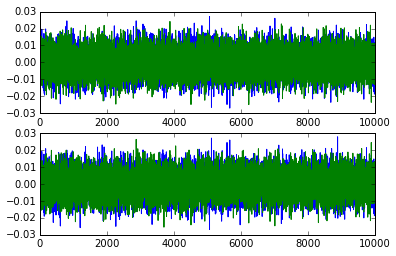

In [65]:
ab = pconv(sph_vecs[0,:], sph_vecs[1,:])
ba = pconv(sph_vecs[1,:], sph_vecs[0,:])

figure();
subplot(211)
plot(real(ab))
plot(imag(ab))
subplot(212)
plot(real(ba))
plot(imag(ba))


In [67]:
cd = np.roll(sph_vecs[2,:], 1) * sph_vecs[3,:]
dc = np.roll(sph_vecs[3,:], 1) * sph_vecs[2, :]

print cd
print dc


[  1.21340541e-04   6.51637018e-05   5.96341852e-05 ...,  -3.81476440e-04
  -1.21022402e-04  -2.60510362e-05]
[  3.37236760e-05   4.19546872e-05   1.04983439e-04 ...,  -7.45617188e-05
  -1.96369762e-04  -1.53575596e-04]


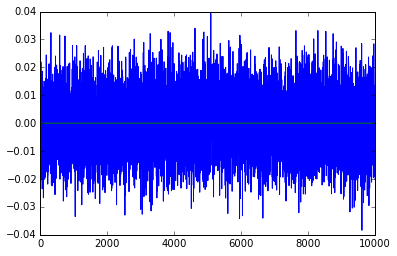

In [45]:
plot(real(ccinv(sph_vecs[0,:])))
plot(imag(ccinv(sph_vecs[0,:])))

In [25]:
s = cconv(sph_vecs[0,:], sph_vecs[1,:])

s2 = cconv(s, ccinv(sph_vecs[0,:]))

print np.dot(s2, sph_vecs[1,:])

0.998282658713


So the circular convolution's inverse is a vector that is $[1, 0, 0, ...]$

In [26]:
np.round(np.real(cconv(sph_vecs[0,:], ccinv(sph_vecs[0,:]))))

array([ 1.,  0.,  0., ...,  0.,  0.,  0.])

Wonderful! Now, we have all of the operations needed for plate's HRR implemented.

![plate95_table1](figures/plate95-cc_operations.png)

In [27]:
print '(1) ', np.dot(sph_vecs[0,:], sph_vecs[0,:])
print '(2) ', np.dot(sph_vecs[0,:], sph_vecs[1,:])
print '(3) ', np.dot(sph_vecs[0,:], cconv(sph_vecs[0,:], sph_vecs[1,:]))
print '(4) ', np.dot(sph_vecs[0,:], cconv(sph_vecs[1,:], sph_vecs[2,:]))
print '(5) ', np.dot(cconv(sph_vecs[0,:], sph_vecs[0,:]), cconv(sph_vecs[0,:], sph_vecs[0,:]))
print '(6) ', np.dot(cconv(sph_vecs[0,:], sph_vecs[1,:]), cconv(sph_vecs[0,:], sph_vecs[1,:]))
print '(7) ', np.dot(cconv(sph_vecs[0,:], sph_vecs[1,:]), cconv(sph_vecs[0,:], sph_vecs[0,:]))
print '(8) ', np.dot(cconv(sph_vecs[0,:], sph_vecs[1,:]), cconv(sph_vecs[0,:], sph_vecs[2,:]))
print '(9) ', np.dot(cconv(sph_vecs[0,:], sph_vecs[1,:]), cconv(sph_vecs[2,:], sph_vecs[2,:]))
print '(10) ', np.dot(cconv(sph_vecs[0,:], sph_vecs[1,:]), cconv(sph_vecs[2,:], sph_vecs[3,:]))

(1)  0.999878503342
(2)  -0.0104812841939
(3)  0.0214391088165
(4)  -0.00730496524023
(5)  1.99232425677
(6)  0.998282658713
(7)  0.00603216695725
(8)  0.0378640313642
(9)  -0.0100582683695
(10)  0.00834875714742


Cool, now we have Plate's HRR encoding established. So, next we can take the statistics of bigrams, but we need one more thing, a roll vector.  

In [97]:
# now we use cconv binding to a roll vector to permute.
roll_vector = hs.sample(1, N)[0,:]

In [59]:
b = cconv(np.roll(letter_vectors[0,:], 1), letter_vectors[1,:])
d = cconv(np.roll(letter_vectors[1,:], 1), letter_vectors[0,:])

c = cconv(letter_vectors[0,:], letter_vectors[1,:])

print b
print c
print d

[-0.00879881 -0.00654484  0.00800373 ...,  0.0167704   0.00738508
 -0.00653239]
[-0.00654484  0.00800373  0.00282742 ...,  0.00738508 -0.00653239
 -0.00879881]
[-0.00879881 -0.00654484  0.00800373 ...,  0.0167704   0.00738508
 -0.00653239]


In [68]:
ngram = 2

alice_vector2 = np.zeros(N)

lidx = random_idx.alphabet.find(alice_text[0])
ngram_vector = letter_vectors[lidx,:]
    
# Now go through the text and accumulate stats
for i,l in enumerate(alice_text[(ngram-1):]):
    if mod(i,1000)==0:
        print i,
        
    lidx = random_idx.alphabet.find(l)
    
    #ngram_vector = cconv(cconv(ngram_vector, roll_vector), letter_vectors[lidx, :])
    
    aidx = random_idx.alphabet.find(alice_text[i])
    bidx = random_idx.alphabet.find(alice_text[i+1])
    
    ngram_vector = np.roll(letter_vectors[aidx,:], 1) * letter_vectors[bidx,:]
    #ngram_vector = ngram_vector / norm(ngram_vector)
    
    alice_vector2 += ngram_vector / norm(ngram_vector)
    
    # remove the first letter of the ngram
    #fidx = random_idx.alphabet.find(alice_text[i])
    #inv_ngram = ccinv(cconv(letter_vectors[fidx,:], roll_vector))

    #ngram_vector = cconv(ngram_vector, inv_ngram)
    
print i
alice_vector2 = alice_vector2 / i


0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 75000 76000 77000 78000 79000 80000 81000 82000 83000 84000 85000 86000 87000 88000 89000 90000 91000 92000 93000 94000 95000 96000 97000 98000 99000 100000 101000 102000 103000 104000 105000 106000 107000 108000 109000 110000 111000 112000 113000 114000 115000 116000 117000 118000 119000 120000 121000 122000 123000 124000 125000 126000 127000 128000 129000 130000 131000 132000 133000 134000 135000 136000 136824


In [30]:
ngram_vector = letter_vectors[2,:]
ngram_vector = cconv(cconv(ngram_vector, roll_vector), letter_vectors[1,:])

inv_ngram = letter_vectors[2,:]
inv_ngram = ccinv(cconv(inv_ngram, roll_vector))

print np.dot(letter_vectors[1,:], cconv(ngram_vector, inv_ngram))

NameError: name 'roll_vector' is not defined

In [69]:
hyp_prob2 = np.zeros(len(random_idx.alphabet)**2)
letter_counts2 = np.zeros(len(random_idx.alphabet)**2)
letter_pairs = []
c = 0

for i, letter1 in enumerate(random_idx.alphabet):
    for j, letter2 in enumerate(random_idx.alphabet):
        
        ls = letter1+letter2
        
        letter_counts2[c] = alice_text.count(ls)
        
        vector = np.roll(letter_vectors[i,:], 1) * letter_vectors[j,:]
        
        hyp_prob2[c] = np.dot(vector/norm(vector), alice_vector2.T)
        
        letter_pairs.append(ls.replace(' ', '_'))

        c+=1

#%%
letter_prob2 = letter_counts2 / sum(letter_counts2)


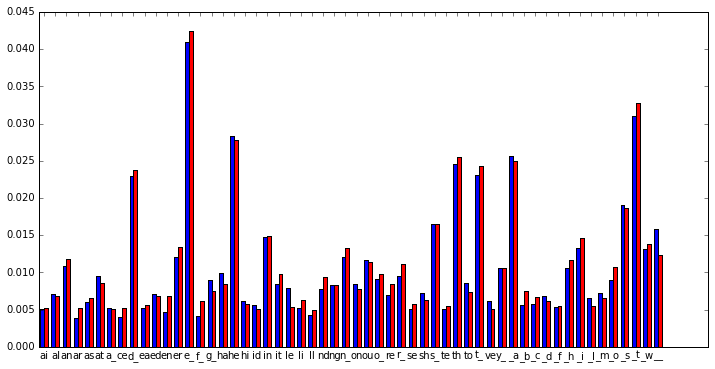

In [70]:
figure(figsize=(12,6))

sig_idx = find(letter_prob2 > 0.005)

b1=bar(arange(len(hyp_prob2[sig_idx]))+0.15, hyp_prob2[sig_idx], width=0.35, color='b')
b2=bar(arange(len(letter_prob2[sig_idx]))+0.5, letter_prob2[sig_idx], width=0.35, color='r')

ax = gca()

ax.set_xticks(arange(len(hyp_prob2[sig_idx]))+0.5)

pair_labels = []
for i in sig_idx:
    pair_labels.append(letter_pairs[i])
    
t1 = ax.set_xticklabels(pair_labels)

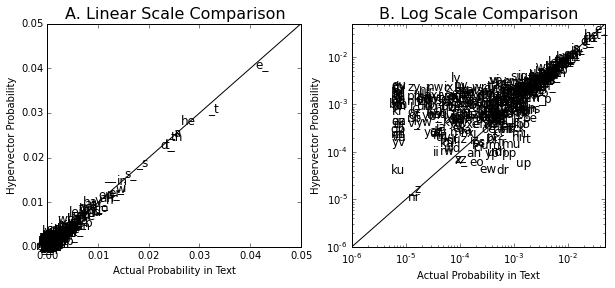

In [71]:
figure(figsize=(10,4))

plt_range = [1e-6, 5e-2]

ax1 = subplot(121)
plot(plt_range, plt_range, 'k')
ax2 = subplot(122)
plot(plt_range, plt_range, 'k')

for i,ll in enumerate(letter_pairs):
    if letter_prob2[i] < 1e-7:
        continue
        
    ax1.text(letter_prob2[i], abs(hyp_prob2[i]), 
             ll, fontsize=12,ha='center', va='center')
    ax2.text(letter_prob2[i], abs(hyp_prob2[i]), 
             ll, fontsize=12,ha='center', va='center')

ax1.set_xlim(plt_range)
ax1.set_ylim(plt_range)
ax1.set_xlabel('Actual Probability in Text')
ax1.set_ylabel('Hypervector Probability')

ax1.set_title('A. Linear Scale Comparison', fontsize=16)

    
ax2.set_xlim(plt_range)
ax2.set_xscale('log')
ax2.set_ylim(plt_range)
ax2.set_yscale('log')

ax2.set_xlabel('Actual Probability in Text')
ax2.set_ylabel('Hypervector Probability')
ax2.set_title('B. Log Scale Comparison', fontsize=16)


So, according to Plate 1995, the circular convolution can be transformed into a matrix multiply for a fixed vector. This takes us towards reconsidering the Plate circular convolution in terms of a recurrent neural network. In fact, Plate even states this idea that circular convolution with a fixed vector can be turned into a matrix multiply and he states that this could be part of a feed-forward neural network. 

> "The convolution operation can be expressed as a matrix-vector multiplication.
$$
    a \oplus b = M_a b
$$
> "where $M_a$ is the matrix corresponding to convolution by $a$. It has elements $m_{a_{ij}}=a_{i-j}$ (where the subscripts on a are interpreted modulo n). Such matrices are known as "circulant matrices" [6]. The eigenvalues of $M_a$ are the individual (complex valued) elements of the Fourier transform of $a$. The corresponding eigenvectors are the inverse transform of the frequency components (i.e., $(1,0,0,...), (0,1,0,...), etc.$ in the frequency domain). Thus it is possible for the mapping computed by the connections between two layers in a feed-forward network (i.e. a matrix multiplication) to correspond to convolution by a fixed vector."

This should mean that the roll vector can be transformed into a weight matrix. And luckily scipy has a built-in function for making the circulant matrix from a given vector.


In [128]:
import scipy

roll_matrix = scipy.linalg.circulant(roll_vector)

In [129]:
roll_matrix

array([[ 0.00024521, -0.00493897,  0.00092119, ...,  0.00159498,
        -0.00662613,  0.00059722],
       [ 0.00059722,  0.00024521, -0.00493897, ..., -0.01240076,
         0.00159498, -0.00662613],
       [-0.00662613,  0.00059722,  0.00024521, ...,  0.00894432,
        -0.01240076,  0.00159498],
       ..., 
       [-0.01451111, -0.00372065, -0.0012587 , ...,  0.00024521,
        -0.00493897,  0.00092119],
       [ 0.00092119, -0.01451111, -0.00372065, ...,  0.00059722,
         0.00024521, -0.00493897],
       [-0.00493897,  0.00092119, -0.01451111, ..., -0.00662613,
         0.00059722,  0.00024521]])

In [130]:
a = np.dot(roll_matrix, sph_vecs[0,:])
b = cconv(roll_vector, sph_vecs[0,:])

In [133]:
print a
print b

[-0.01047629 -0.00363775  0.02248614 ...,  0.00850284  0.00049768
  0.00738371]
[-0.01047629 -0.00363775  0.02248614 ...,  0.00850284  0.00049768
  0.00738371]


So, this leads us directly back to the notion of using the vector symbolic architectures as the basis for recurrent neural networks. The roll_matrix acting in time like the feedback connections of a recurrent neural network and the input streaming in to the network at each time step. 

Plate already realized this could be used to understand the function of neural networks!

In [ ]:
u,s,v = svd(roll_matrix)